In [22]:
#Import relevant libraries
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import datetime


In [23]:
#Define the hyperparameters
BUFFER_SIZE = 70_000
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [24]:
#Download the dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info = True, as_supervised=True)

mnist_train, mnist_test = mnist_dataset['train'],  mnist_dataset['test']


#Scaling the dataset. Fist cast the image to avoid value error
def scale(image,label):
    image = tf.cast(image, tf.float32)
    image /= 225.
    
    return image, label
    

In [25]:
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

#creating the number of validation dataset from the training dataset
num_validation_samples = 0.1*mnist_info.splits['train'].num_examples

#convert number of the validation sample to an integer to prevent potential issue
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

#get the number data point in our  test samples
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

#Shuffle the training and validation dataset
shuffle_train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)


#create the train data
train_data = shuffle_train_and_validation_data.skip(num_validation_samples)

#create the validation data
validation_data = shuffle_train_and_validation_data.take(num_validation_samples)


#batching the training data

train_data = train_data.batch(BATCH_SIZE)

#No need to batch the validation and test data(we are not backpropagating on them ). Hence we will take all at once]
validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

validation_inputs, validation_targets = next(iter(validation_data))




 

In [26]:
#Creating the model
model = Sequential([
        Conv2D(50, 5, activation= 'relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(50, 3, activation= 'relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(10)
])

In [27]:
model.summary(line_length=75)

Model: "sequential_2"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d_4 (Conv2D)               (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d_4 (MaxPooling2D)  (None, 12, 12, 50)            0           
                                                                           
 conv2d_5 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_5 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten_2 (Flatten)             (None, 1250)                  0           
                                                                           
 dense_2 (Dense)                 (None, 10)                    125

In [28]:
#describe the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#Compile the model

model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])


#Stop the model from overfitting ie whenever the validation loss increases
#the code tells the model to stop when the val_loss starts to increase in two subsequent epics

early_stopping = EarlyStopping(
    monitor= 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0,
    restore_best_weights = True
)

In [29]:
#Get the current date and time as a string
current_datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#Create a log directory based on the current date and time
#log_dir = "logs\\fit\\"{current_datetime}
log_dir = f'./logs/{current_datetime}'

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [30]:
#Train the model
model.fit(
    train_data,
    epochs = NUM_EPOCHS,
    callbacks = [tensorboard_callback, early_stopping],
    validation_data = validation_data,
    verbose =2
)

Epoch 1/20
422/422 - 36s - loss: 0.2662 - accuracy: 0.9245 - val_loss: 0.0823 - val_accuracy: 0.9745 - 36s/epoch - 86ms/step
Epoch 2/20
422/422 - 38s - loss: 0.0703 - accuracy: 0.9788 - val_loss: 0.0606 - val_accuracy: 0.9805 - 38s/epoch - 89ms/step
Epoch 3/20
422/422 - 35s - loss: 0.0526 - accuracy: 0.9839 - val_loss: 0.0406 - val_accuracy: 0.9867 - 35s/epoch - 82ms/step
Epoch 4/20
422/422 - 34s - loss: 0.0420 - accuracy: 0.9871 - val_loss: 0.0351 - val_accuracy: 0.9900 - 34s/epoch - 81ms/step
Epoch 5/20
422/422 - 35s - loss: 0.0363 - accuracy: 0.9889 - val_loss: 0.0335 - val_accuracy: 0.9897 - 35s/epoch - 83ms/step
Epoch 6/20
422/422 - 38s - loss: 0.0309 - accuracy: 0.9901 - val_loss: 0.0256 - val_accuracy: 0.9917 - 38s/epoch - 90ms/step
Epoch 7/20
422/422 - 40s - loss: 0.0277 - accuracy: 0.9914 - val_loss: 0.0234 - val_accuracy: 0.9923 - 40s/epoch - 95ms/step
Epoch 8/20
422/422 - 45s - loss: 0.0239 - accuracy: 0.9925 - val_loss: 0.0160 - val_accuracy: 0.9957 - 45s/epoch - 107ms/step

In [31]:
#Test the model
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Loss: {round(test_loss,2)}. Test Accuracy:{round(test_accuracy*100,2)}%')

1/1 [==============================] - 2s 2s/step - loss: 0.0266 - accuracy: 0.9914
Test Loss: 0.03. Test Accuracy:99.14%


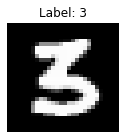

In [32]:

#Plot the image and result
import matplotlib.pyplot as plt
import numpy as np


# Get and display the first n images from the training dataset. n=2
num_images_to_display = 1
for image, label in test_data.take(num_images_to_display):
    sample_image = image.numpy()# Convert to numpy array and remove singleton dimensions
    sample_label = label.numpy()

original_images = sample_image.reshape(10000, 28, 28)

# Display the image using matplotlib
image_number_to_display = 8

plt.figure(figsize=(2,2))
plt.imshow(sample_image[image_number_to_display], cmap='gray', aspect="auto")
plt.title(f'Label: {sample_label[image_number_to_display]}')
plt.axis('off')  # Turn off axis
plt.show()

1/1 [==============================] - 0s 102ms/step


<BarContainer object of 10 artists>

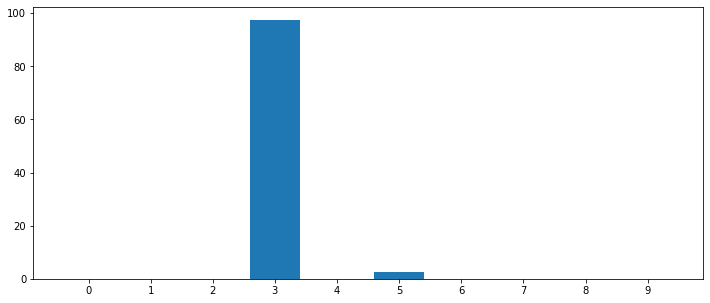

In [33]:
#Obtain the model's prediction(logits)

#Using slicing is important because tensorflow expects inputs to be in batches
predictions = model.predict(sample_image[image_number_to_display:image_number_to_display+1])

#Convert the predictions into probabilities and to percentage
probabilities = (tf.nn.softmax(predictions).numpy()) *100

#Create a bar chart to plot the probabilities for each class
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0", "1","2","3","4","5","6","7","8","9"])

In [34]:
#VIsualize the Tensorboard
%load_ext tensorboard
%tensorboard --logdir ./logs

